In [26]:
#!/usr/bin/env py
'''
Set dependencies and python shebang
'''
from configpath import configpath  # Config path
from configparser import ConfigParser  # Load config
from psycopg2 import connect  # Connect to database
import numpy as np  # Arrays for stats
from sklearn.linear_model import LinearRegression  # Regression
from sklearn.model_selection import train_test_split  # Train-test
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
plt.style.use('ggplot')


In [13]:
def load_config(configpath, section):
    '''
    Use configparser to load the .ini file
    '''
    parser = ConfigParser()  # Create parser
    parser.read(configpath)  # Read config ini file
    config = {}  # Create empty dictionary for config
    if parser.has_section(section):  # Look for 'config' section in config ini file
        params = parser.items(section)  # Parse config ini file
        for param in params:  # Loop through parameters
            config[param[0]] = param[1]  # Set key-value pair for parameter in dictionary
    else:  # Raise exception if the section can't be found
        raise Exception(
            'Section {0} not found in the {1} file'.format(section, configpath))
    return config

In [14]:
def create_connector(con_config, db_config):
    '''
    Create psycopg2 connector for database
    '''
    con = connect(database=db_config['dbname'], port=con_config['port'],
                  user=con_config['user'], password=con_config['password'],
                  host=con_config['host'])
    return con

In [15]:
def execute_query(con, query):
    '''
    Execute an inputted query on the connected database, fetch the result,
    and return it
    '''
    try:
        cur = con.cursor()
        cur.execute(query)
        result = cur.fetchall()
        result = [item for t in result for item in t]  # Unpack tuples
        cur.close()
        return result
    except:  # If there is an error, close cursor and reset connection
        cur.close()
        create_connector(con_config, db_config)

In [16]:
def divide_chunks(l, n):
    '''
    Chunk list l into nested lists of size n.
    '''
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [17]:
'''
Load configs and create connection object
'''
con_config = load_config(configpath, 'postgres_connection')  # Load postgres connection config
db_config = load_config(configpath, 'createdb')  # Load database config
con = create_connector(con_config, db_config)  # Create database connector

In [18]:
'''
Create linear model object and other necessary statistics objects
'''
lr = LinearRegression()

In [19]:
'''
Start with a simple analysis.
Test whether there is a difference between elapsed tv time for weekdays vs. weekends.
Query dataset, chunk rows into nested lists, and convert to numpy array.
Innermost statement is the SQL query.
Following that is the number of chunks, which is the number of variables fetched from the database.
Next is to pack those observation-level lists into a master-list.
The list of lists is then converted into a numpy array.
Convert estimated time from ms to minutes.
Contrast-code weekday/weekend. 
'''
dataset = np.array(list(divide_chunks(execute_query(con, "SELECT CAST(tv_data_sample.elapsed_time AS numeric), tv_data_sample.week_day_end FROM tv_data_sample;"), 2)))
dataset[:,1] = np.where(dataset[:,1]=='Weekday', 0.5, dataset[:,1])  # Contrast code weekday
dataset[:,1] = np.where(dataset[:,1]=='Weekend', -0.5, dataset[:,1])  # Contrast code weekend
dataset[:,0] = (dataset[:,0].astype(float)/1000)/60  # Convert elapsed time from ms to minutes

There are 354086 Weekday observations
Mean Weekday elapsed time is 15.79
Standard deviation Weekday elapsed time is 20.63

There are 145919 Weekday observations
Mean Weekend elapsed time is 18.04
Standard deviation Weekend elapsed time is 25.68


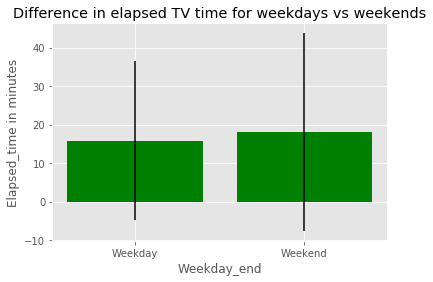

In [20]:
'''
Descriptive stats and data visualization.
'''
print("There are " + str(dataset[np.where(dataset[:,1] == 0.5),0].size) + " Weekday observations")
print("Mean Weekday elapsed time is " + str(round(dataset[np.where(dataset[:,1] == 0.5),0].mean(), 2)))
print("Standard deviation Weekday elapsed time is " + str(round(dataset[np.where(dataset[:,1] == 0.5),0].std(), 2)))
print("")
print("There are " + str(dataset[np.where(dataset[:,1] == -0.5),0].size) + " Weekday observations")
print("Mean Weekend elapsed time is " + str(round(dataset[np.where(dataset[:,1] == -0.5),0].mean(), 2)))
print("Standard deviation Weekend elapsed time is " + str(round(dataset[np.where(dataset[:,1] == -0.5),0].std(), 2)))


x_labels = ['Weekday', 'Weekend']
y_means = [dataset[np.where(dataset[:,1] == 0.5),0].mean(), dataset[np.where(dataset[:,1] == -0.5),0].mean()]
errors = [dataset[np.where(dataset[:,1] == 0.5),0].std(), dataset[np.where(dataset[:,1] == -0.5),0].std()]

x_pos = [i for i, _ in enumerate(x_labels)]

plt.bar(x_pos, y_means, yerr=errors, color='green')
plt.xlabel("Weekday_end")
plt.ylabel("Elapsed_time in minutes")
plt.title("Difference in elapsed TV time for weekdays vs weekends")

plt.xticks(x_pos, x_labels)

plt.show()


In [47]:
'''
Test whether there is a difference between elapsed tv time for weekdays vs. weekends.
Create linear model with 80% test, 20% train. (This may be overkill for a simple model, but just as a demonstration /
arguably best practice to test for overfit and other performance measures)
Use model to make prediction for test set.
'''

X_train, X_test, y_train, y_test = train_test_split(dataset[:,0].reshape(-1,1), dataset[:,1], test_size=0.2, random_state=0)

lr.fit(X_train, y_train, sample_weight=None)

y_pred = lr.predict(X_test)

print("Intercept: " + str(lr.intercept_))
print("Slope: " + str(lr.coef_))
print("R^2 Explained Variance Train set: " + str(lr.score(X_train, y_train)))
print("R^2 Explained Variance Test set: " + str(lr.score(X_test, y_test)))

'''
These results suggest that whether or not it is a weekday vs. a weekend explains only a small amount
of variance in elapsed time watching TV. On weekdays, people watched ~0.0009 minutes less TV than on weekends.
'''

Intercept: 0.22369235203922497
Slope: [-0.00093548]
R^2 Explained Variance Train set: 0.0020877638527766473
R^2 Explained Variance Test set: 0.0022436543143231624


In [ ]:
'''
Query dataset for analyses, chunk rows into nested lists, and convert to a numpy array.
'''
dataset = np.array(list(divide_chunks(execute_query(con, "SELECT CAST(tv_data_sample.elapsed_time AS numeric), CAST(tv_data_sample.show_duration AS numeric), tv_data_sample.week_day_end, CAST(app_data_sample.total_minutes AS numeric) AS appmins, CAST(web_data_sample.total_minutes AS numeric) AS webmins FROM tv_data_sample INNER JOIN app_data_sample ON tv_data_sample.users_meta_id = app_data_sample.users_meta_id INNER JOIN web_data_sample ON tv_data_sample.users_meta_id = web_data_sample.users_meta_id;"), 5)))
dataset[:,2] = np.where(dataset[:,2]=='Weekday', 0.5, dataset[:,2])  # Contrast code weekday
dataset[:,2] = np.where(dataset[:,2]=='Weekend', -0.5, dataset[:,2])  # Contrast code weekend
dataset[:,0] = (dataset[:,0]/1000)/60  # Convert elapsed time from ms to minutes
dataset[:,1] = (dataset[:,1]/1000)/60  # Convert show duration from ms to minutes
dataset[:,0] = dataset[:,0].astype(int)  # Convert numeric data to int
dataset[:,1] = dataset[:,1].astype(int)
dataset[:,3] = dataset[:,3].astype(int)
dataset[:,4] = dataset[:,4].astype(int)

In [ ]:
'''
Run correlation as a linear model
'''
lr.fit(appmins, webmins)

In [ ]:
'''
Set up data table
'''
params = np.append(lr.intercept_, lr.coef_)
predictions = lr.predict(appmins)
new_appmins = np.append(np.ones((len(appmins), 1)), appmins, axis=1)
MSE = (sum((webmins-predictions)**2))/(len(new_appmins)-len(new_appmins[0]))
var_b = MSE*(np.linalg.inv(np.dot(new_appmins.T, new_appmins)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params / sd_b
p_values = [2*(1-stats.t.cdf(np.abs(i),(len(new_appmins)-1))) for i in ts_b]
sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)
